C:\Users\DELL\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Average Reward over training episodes: 19.19
Average Reward over evaluation episodes: 13.15

Total Rewards per episode: [75.0, 5.0, 10.0, 15.0, 5.0, 15.0, 50.0, 60.0, 50.0, 50.0, 40.0, 30.0, 45.0, 15.0, 30.0, 0.0, 65.0, 15.0, 75.0, 5.0, 5.0, 30.0, 30.0, 30.0, 50.0, 5.0, 50.0, 15.0, 15.0, 20.0, 0.0, 50.0, 5.0, 15.0, 75.0, 20.0, 5.0, 15.0, 35.0, 50.0, 10.0, 50.0, 5.0, 30.0, 15.0, 0.0, 20.0, 0.0, 15.0, 30.0, 15.0, 10.0, 40.0, 50.0, 30.0, 30.0, 30.0, 0.0, 0.0, 0.0, 5.0, 30.0, 20.0, 55.0, 50.0, 20.0, 20.0, 5.0, 15.0, 0.0, 0.0, 0.0, 15.0, 5.0, 35.0, 10.0, 20.0, 20.0, 0.0, 60.0, 35.0, 25.0, 15.0, 75.0, 0.0, 30.0, 30.0, 0.0, 20.0, 35.0, 50.0, 5.0, 40.0, 55.0, 5.0, 15.0, 75.0, 0.0, 30.0, 10.0, 50.0, 50.0, 30.0, 5.0, 20.0, 30.0, 15.0, 5.0, 5.0, 5.0, 25.0, 15.0, 5.0, 30.0, 15.0, 30.0, 35.0, 15.0, 5.0, 5.0, 30.0, 35.0, 15.0, 30.0, 10.0, 15.0, 35.0, 25.0, 35.0, 5.0, 50.0, 25.0, 5.0, 50.0, 5.0, 30.0, 30.0, 10.0, 30.0, 30.0, 50.0, 50.0, 15.0, 15.0, 5.0, 50.0, 30.0, 15.0, 35.0, 5.0, 50.0, 5.0, 10.0, 3

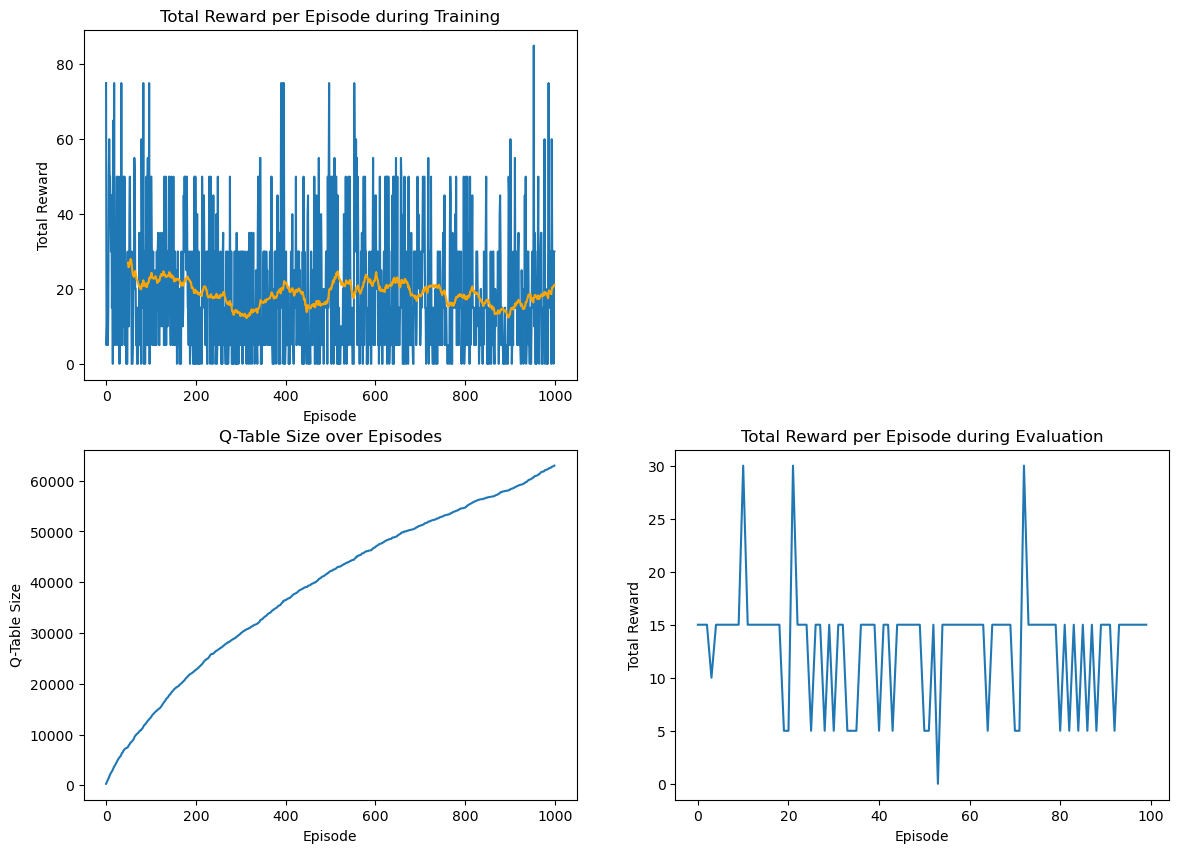

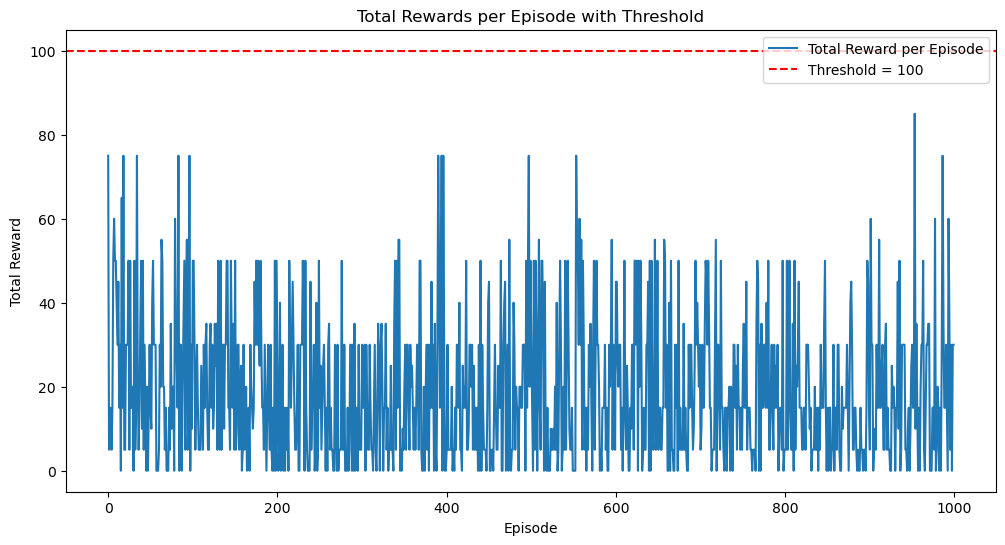

<Figure size 640x480 with 0 Axes>

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from gym.wrappers import AtariPreprocessing, FrameStack

# Preprocessing Functions
def preprocess_state(state):
    if len(state.shape) == 3:  
        return np.mean(state, axis=2).astype(np.uint8)[::2, ::2]  
    return state

def discretize_state(state, bins=(10, 10)):
    if isinstance(state, np.ndarray):  
        return tuple(state.flatten()[:bins[0] * bins[1]])
    raise ValueError("State is not a valid NumPy array!")

# Q-Learning Algorithm
def q_learning(env, alpha, gamma, epsilon, min_epsilon, epsilon_decay, num_episodes, max_steps_per_episode):
    q_table = {} #it stores q-values
    episode_rewards = []
    q_table_sizes = []

    for episode in range(num_episodes):
        obs, _ = env.reset()  
        state = preprocess_state(obs)  
        state = discretize_state(state)  

        total_reward = 0
        for step in range(max_steps_per_episode):
            # Epsilon-greedy action selection
            if state not in q_table:
                q_table[state] = np.zeros(env.action_space.n)
            if np.random.random() < epsilon:
                action = env.action_space.sample()  
            else:
                action = np.argmax(q_table[state])  

            # Take the action
            next_obs, reward, terminated, truncated, _ = env.step(action)
            next_state = discretize_state(preprocess_state(next_obs))
            total_reward += reward

            # Update Q-value
            if next_state not in q_table:
                q_table[next_state] = np.zeros(env.action_space.n)
            best_next_action = np.argmax(q_table[next_state])
            q_table[state][action] += alpha * (
                reward + gamma * q_table[next_state][best_next_action] - q_table[state][action]
            )

            state = next_state  # Transition to next state
            if terminated or truncated:
                break

        # Decay epsilon
        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        episode_rewards.append(total_reward)
        q_table_sizes.append(len(q_table))

    return q_table, episode_rewards, q_table_sizes

# Evaluation Function
def evaluate_policy(env, q_table, num_episodes, max_steps_per_episode):
    total_rewards = []
    for episode in range(num_episodes):
        obs, _ = env.reset()
        state = discretize_state(preprocess_state(obs))
        total_reward = 0

        for step in range(max_steps_per_episode):
            if state in q_table:
                action = np.argmax(q_table[state])  
            else:
                action = env.action_space.sample() 
            next_obs, reward, terminated, truncated, _ = env.step(action)
            state = discretize_state(preprocess_state(next_obs))
            total_reward += reward
            if terminated or truncated:
                break

        total_rewards.append(total_reward)

    average_reward = np.mean(total_rewards)
    return average_reward, total_rewards

# Hyperparameters
alpha = 0.1  # Learning rate -->its like agent collect the new information and updates it 
gamma = 0.99  # Discount factor -->its agent values the future rewards
epsilon = 1.0  # exploration rate --> here the agent tries different actions and makes decisions 
min_epsilon = 0.1  # Minimum exploration rate
epsilon_decay = 0.995  # Decay rate for epsilon
num_episodes = 1000  # Total number of episodes
max_steps_per_episode = 500  # Maximum steps per episode

# Environment Setup
env = gym.make('SpaceInvadersNoFrameskip-v4')  
env = AtariPreprocessing(env, frame_skip=1)   
env = FrameStack(env, 4)                       

# Train the Q-learning agent
q_table, episode_rewards, q_table_sizes = q_learning(env, alpha, gamma, epsilon, min_epsilon, epsilon_decay, num_episodes, max_steps_per_episode)

# Calculate average reward over training episodes
average_training_reward = np.mean(episode_rewards)
print(f"Average Reward over training episodes: {average_training_reward}")

# Evaluate the policy
average_reward, evaluation_rewards = evaluate_policy(env, q_table, num_episodes=100, max_steps_per_episode=max_steps_per_episode)

# Print Results
print(f"Average Reward over evaluation episodes: {average_reward}")

print(f"\nTotal Rewards per episode: {episode_rewards}")

print(f"\nEvaluation Rewards per episode: {evaluation_rewards}")

print(f"\nQ-Table sizes over episodes: {q_table_sizes}")

# Plotting the results
plt.figure(figsize=(14, 10))

# Plot episode rewards over training
plt.subplot(2, 2, 1)
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode during Training')

# here we are Plotting moving average of rewards
window_size = 50
smoothed_rewards = np.convolve(episode_rewards, np.ones(window_size)/window_size, mode='valid')
plt.plot(range(window_size - 1, num_episodes), smoothed_rewards, color='orange')
plt.title('Total Reward per Episode during Training')

# setting the threshold value 
#plt.subplot(2, 2, 2)
reward_threshold = 100  

# Identify episodes where the reward meets or exceeds the threshold
episodes_to_reach_threshold = [i for i, reward in enumerate(episode_rewards) if reward >= reward_threshold]

if not episodes_to_reach_threshold:
    print("No episodes reached the reward threshold.")
else:
    print(f"Episodes that reached the threshold: {episodes_to_reach_threshold}")

#Q-Table size over episodes
plt.subplot(2, 2, 3)
plt.plot(q_table_sizes)
plt.xlabel('Episode')
plt.ylabel('Q-Table Size')
plt.title('Q-Table Size over Episodes')

# Plot average reward per episode (evaluation)
plt.subplot(2, 2, 4)
plt.plot(evaluation_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode during Evaluation')

# Set the threshold value 
reward_threshold = 100  

# Plot total rewards per episode 
plt.figure(figsize=(12, 6))
plt.plot(episode_rewards, label='Total Reward per Episode')
plt.axhline(y=reward_threshold, color='r', linestyle='--', label=f'Threshold = {reward_threshold}')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Rewards per Episode with Threshold')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()
